TODO:
- Add pm2??
- Check disp=True in real model
- lower number of nodes in real model?


In [1]:
import pathlib
import pickle

import astropy.coordinates as coord
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jax.scipy as jsci
from jax.random import PRNGKey

import numpyro
numpyro.enable_x64()

from numpyro_ext.optim import optimize

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn
import scipy.special as scsp

from stream_membership import SplineDensityMixtureModel
from stream_membership.helpers import two_truncated_normal_mixture, two_normal_mixture
from stream_membership.plot import plot_data_projections
from stream_membership.truncnorm import CustomTruncatedNormal, rvs as truncnorm_rvs
from gd1_helpers.membership.initialize import BackgroundInitializer, StreamInitializer

In [2]:
class GD1ComponentBase:
    coord_names = ("phi2", "pm1") # , "pm2")
    coord_bounds = {"phi1": (-100, 20), "phi2": (-7, 5), "pm1": (-15, -1.)} # , "pm1": (-15, -1.)

    default_grids = {
        "phi1": np.arange(*coord_bounds["phi1"], 0.2),
        "phi2": np.arange(*coord_bounds["phi2"], 0.1),
        "pm1": np.arange(*coord_bounds["pm1"], 0.1),
        # "pm2": np.arange(*coord_bounds["pm2"], 0.1),
    }

# Fake data

In [3]:
rng = np.random.default_rng(seed=42)
jax_rng = PRNGKey(seed=42)

In [4]:
N_bkg = 10_000
N_str = N_bkg // 5

In [41]:
bkg_data = {}

tmp = CustomTruncatedNormal(
    loc=0, scale=60, 
    low=GD1ComponentBase.coord_bounds['phi1'][0], 
    high=GD1ComponentBase.coord_bounds['phi1'][1]
)
bkg_data['phi1'] = tmp.sample(jax_rng, sample_shape=(N_bkg,))
bkg_data['phi2'] = rng.uniform(*GD1ComponentBase.coord_bounds['phi2'], size=N_bkg)

_lim = GD1ComponentBase.coord_bounds['pm1']
_loc = 4.3
_scale = 5.
a = (_lim[0] - _loc) / _scale
b = (_lim[1] - _loc) / _scale
bkg_data['pm1'] = scs.truncnorm.rvs(a, b, loc=_loc, scale=_scale, size=(N_bkg, ), 
                                    random_state=rng)
# bkg_data['pm1_err'] = 10 ** rng.uniform(-2, -0.5, size=N_bkg)
bkg_data['pm1_err'] = np.zeros(len(bkg_data['pm1']))
bkg_data['pm1'] = rng.normal(bkg_data['pm1'], bkg_data['pm1_err'])

In [42]:
stream_data = {}

tmp = CustomTruncatedNormal(
    loc=-60, scale=50, 
    low=GD1ComponentBase.coord_bounds['phi1'][0], 
    high=GD1ComponentBase.coord_bounds['phi1'][1]
)
stream_data['phi1'] = tmp.sample(jax_rng, sample_shape=(N_str,))

_phi2_func = lambda x: -((x - -40) / 25.)**2 + 0.5
# _grid = np.linspace(-100, 20, 128)
# plt.plot(_grid, _phi2_func(_grid))
stream_data['phi2'] = rng.normal(_phi2_func(stream_data['phi1']), 0.25, size=N_str)

_pm1_func = lambda x: ((x - -40) / 25.)**2 - 10
# _grid = np.linspace(-100, 20, 128)
# plt.plot(_grid, _pm1_func(_grid))
stream_data['pm1'] = rng.normal(_pm1_func(stream_data['phi1']), 0.1, size=N_str)
# stream_data['pm1_err'] = 10 ** rng.uniform(-2, 0., size=N_str)
stream_data['pm1_err'] = np.zeros(len(stream_data['pm1']))
stream_data['pm1'] = rng.normal(stream_data['pm1'], stream_data['pm1_err'])

In [43]:
all_data = {k: np.concatenate((stream_data[k], bkg_data[k])) for k in stream_data}

(<Figure size 720x432 with 2 Axes>,
 array([<AxesSubplot: ylabel='$\\phi_2$'>,
        <AxesSubplot: ylabel='$\\mu_{\\phi_1}$'>], dtype=object))

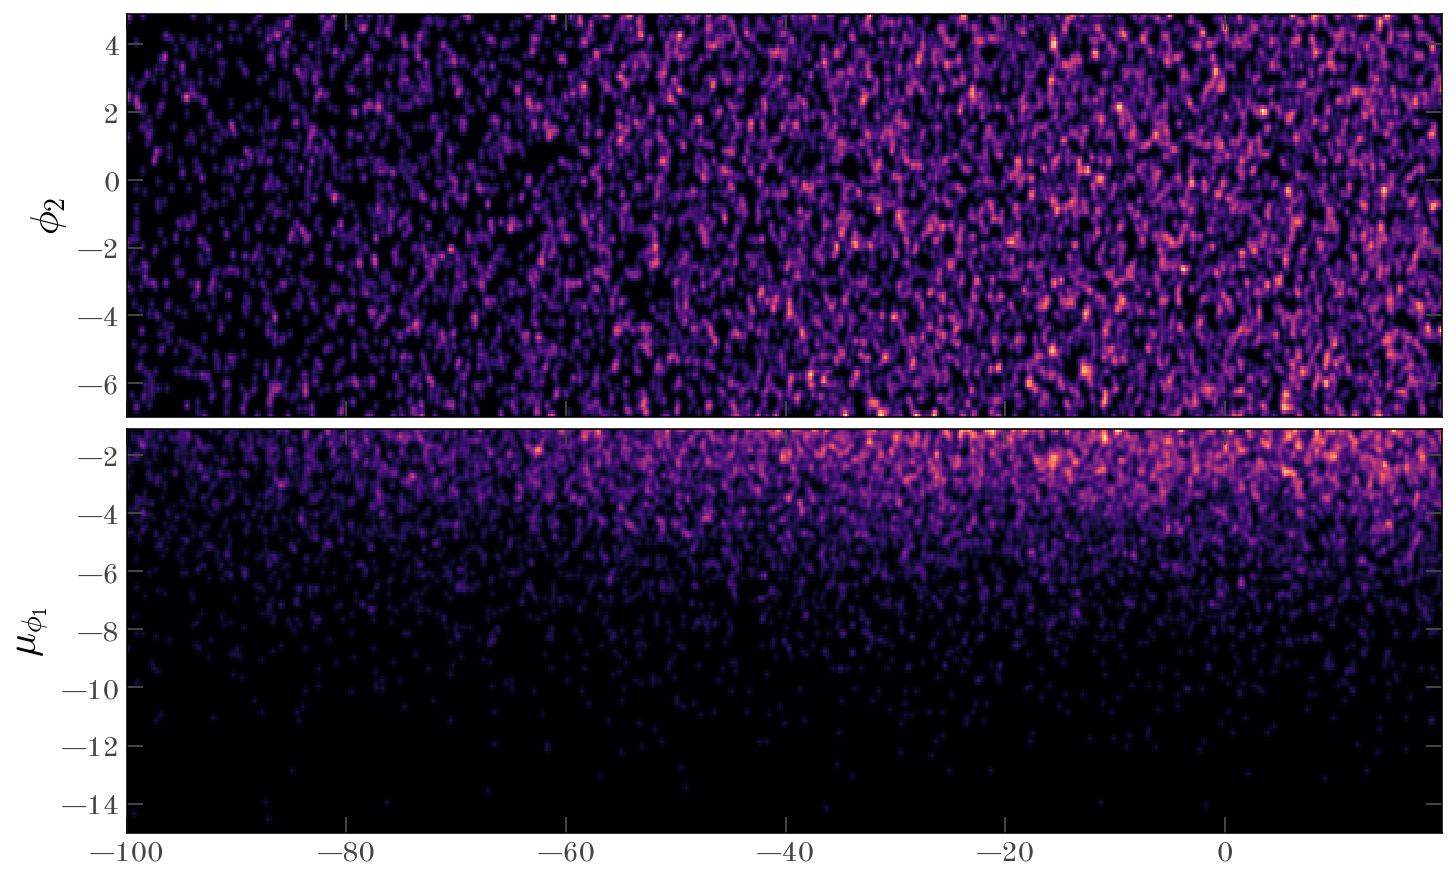

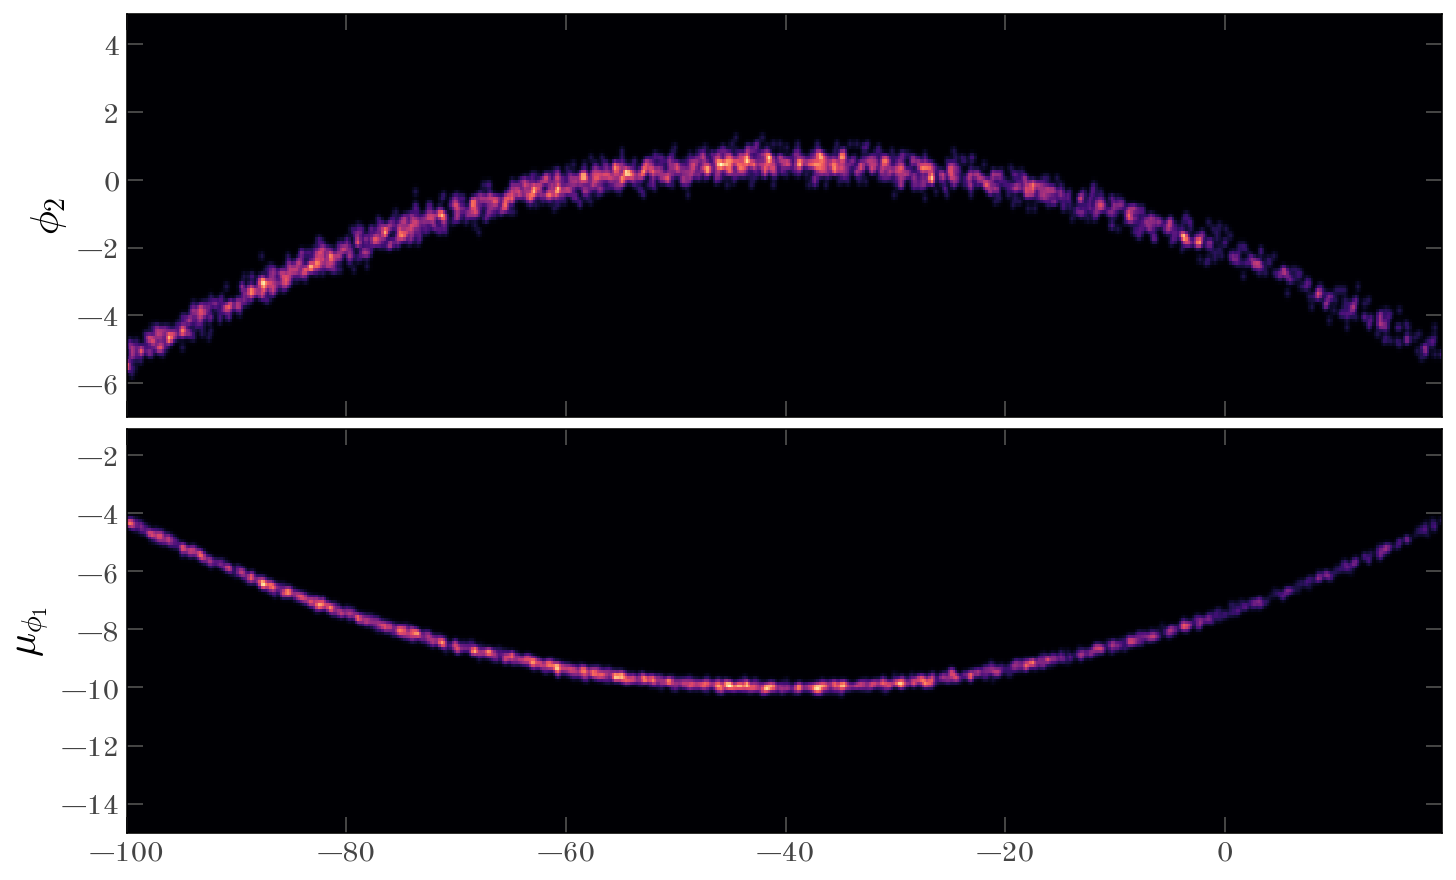

In [44]:
plot_data_projections(bkg_data, grids=GD1ComponentBase.default_grids)
plot_data_projections(stream_data, grids=GD1ComponentBase.default_grids)

# Model definition

## Base:

In [45]:
import numpyro.distributions as dist
from gd1_helpers.membership.gd1_model import _get_knots
from stream_membership import SplineDensityModelBase

## Background

In [161]:
phi1_lim = GD1ComponentBase.coord_bounds['phi1']


class GD1BackgroundModel(GD1ComponentBase, SplineDensityModelBase):
    name = "background"

    knots = {
        "ln_n0": _get_knots(*phi1_lim, 9, arange=False),
        "pm1": _get_knots(*phi1_lim, 7, arange=False),
    }
    param_bounds = {
        "ln_n0": (-5, 8),
        "phi2": {},
        "pm1": {
            "mean": (-5, 20),
            "ln_std": (-1, 5),
        },
    }

    # Can probably use a lower resolution grid here?
    integration_grid_phi1 = jnp.arange(phi1_lim[0], phi1_lim[1] + 1e-3, 0.1)

    @classmethod
    def setup_numpyro(cls, data=None):
        pars = {}

        # ln_n0 : linear density
        bounds = cls.param_bounds["ln_n0"]
        pars["ln_n0"] = numpyro.sample(
            f"ln_n0_{cls.name}",
            # dist.Uniform(*bounds),
            dist.Normal(loc=0.5 * (bounds[0] + bounds[1]), scale=0.5 * (bounds[1] - bounds[0])),
            sample_shape=(len(cls.knots["ln_n0"]),),
        )
        
        coord_name = "pm1"
#         pars[coord_name] = {}
#         for par_name in ["mean", "ln_std"]:
#             pars[coord_name][par_name] = numpyro.sample(
#                 f"{coord_name}_{par_name}_{cls.name}",
#                 dist.Uniform(*cls.param_bounds[coord_name][par_name]),
#                 sample_shape=(len(cls.knots[coord_name]),),
#             )
            
        pars[coord_name] = {}
        for par_name in ["mean", "ln_std"]:
            bounds = cls.param_bounds[coord_name][par_name]
            pars[coord_name][par_name] = numpyro.sample(
                f"{coord_name}_{par_name}_{cls.name}",
                # dist.Uniform(*bounds),
                dist.Normal(loc=0.5 * (bounds[0] + bounds[1]), scale=0.5 * (bounds[1] - bounds[0])),
                sample_shape=(len(cls.knots[coord_name]),),
            )

        return cls(pars=pars, data=data)

    def get_dists(self, data):
        dists = {}

        if "phi2" in self.coord_names:
            dists["phi2"] = dist.Uniform(-7, jnp.full(len(data["phi1"]), 5))

        if "pm1" in self.coord_names:
            var = jnp.exp(2 * self.splines["pm1"]["ln_std"](data["phi1"])) + data["pm1_err"]**2
            dists["pm1"] = dist.TruncatedNormal(
                loc=self.splines["pm1"]["mean"](data["phi1"]),
                scale=jnp.sqrt(var),
                low=self.coord_bounds["pm1"][0],
                high=self.coord_bounds["pm1"][1],
            )

        return dists

## Stream

In [162]:
class GD1StreamModel(GD1ComponentBase, SplineDensityModelBase):
    name = "stream"

    knots = {
        "ln_n0": _get_knots(*phi1_lim, 30.0),
        "phi2": _get_knots(*phi1_lim, 10.0),
        "pm1": _get_knots(*phi1_lim, 10.0),
    }

    param_bounds = {
        "ln_n0": (-5, 8),
        "phi2": {"mean": GD1ComponentBase.coord_bounds["phi2"], "ln_std": (-2, 0.5)},
        "pm1": {"mean": GD1ComponentBase.coord_bounds["pm1"], "ln_std": (-5, 1)}, 
    }
    
    spline_ks = {
        "phi2": {
            "mean": 2,
            "ln_std": 2
        },
        "pm1": {
            "mean": 2,
            "ln_std": 2
        },
    }

    integration_grid_phi1 = jnp.arange(phi1_lim[0], phi1_lim[1] + 1e-3, 0.2)
    
    @classmethod
    def setup_numpyro(cls, data=None):
        pars = {}

        # ln_n0 : linear density
        bounds = cls.param_bounds["ln_n0"]
        pars["ln_n0"] = numpyro.sample(
            f"ln_n0_{cls.name}",
            # dist.Uniform(*bounds),
            dist.Normal(loc=0.5 * (bounds[0] + bounds[1]), scale=0.5 * (bounds[1] - bounds[0])),
            sample_shape=(len(cls.knots["ln_n0"]),),
        )

        # Other coordinates:
        for coord_name in cls.coord_names:
            pars[coord_name] = {}
            for par_name in ["mean", "ln_std"]:
                bounds = cls.param_bounds[coord_name][par_name]
                pars[coord_name][par_name] = numpyro.sample(
                    f"{coord_name}_{par_name}_{cls.name}",
                    # dist.Uniform(*bounds),
                    dist.Normal(loc=0.5 * (bounds[0] + bounds[1]), scale=0.5 * (bounds[1] - bounds[0])),
                    sample_shape=(len(cls.knots[coord_name]),),
                )

        return cls(pars=pars, data=data)

    def get_dists(self, data):
        dists = {}
        dists["ln_n0"] = self.splines["ln_n0"]
        
        if "phi2" in self.coord_names:
            # dists["phi2"] = CustomTruncatedNormal(
            dists["phi2"] = dist.TruncatedNormal(
                loc=self.splines["phi2"]["mean"](data["phi1"]),
                scale=jnp.exp(self.splines["phi2"]["ln_std"](data["phi1"])),
                low=self.coord_bounds["phi2"][0],
                high=self.coord_bounds["phi2"][1],
            )
            
        if "pm1" in self.coord_names:
            var = jnp.exp(2 * self.splines["pm1"]["ln_std"](data["phi1"])) + data["pm1_err"]**2
            # dists["pm1"] = CustomTruncatedNormal(
            # dists["pm1"] = dist.TruncatedNormal(
            #     loc=self.splines["pm1"]["mean"](data["phi1"]),
            #     scale=jnp.sqrt(var),
            #     low=self.coord_bounds["pm1"][0],
            #     high=self.coord_bounds["pm1"][1],
            # )
            dists["pm1"] = dist.Normal(
                loc=self.splines["pm1"]["mean"](data["phi1"]),
                scale=jnp.sqrt(var)
            )
            
        return dists
    
    def extra_ln_prior(self):
        lp = 0.0

        lp += (
            dist.Normal(0, 0.25)
            .log_prob(self.splines["ln_n0"]._y[1:] - self.splines["ln_n0"]._y[:-1])
            .sum()
        )

        std_map = {"mean": 0.5, "ln_std": 0.1}
        for coord_name in self.coord_names:
            for par_name in self.splines[coord_name]:
                for check in ["mean", "ln_std"]:
                    if check in par_name:
                        std = std_map[check]
                        break
                else:
                    std = 1.

                spl_y = self.splines[coord_name][par_name]._y
                lp += dist.Normal(0, std).log_prob(spl_y[1:] - spl_y[:-1]).sum()

        return lp

In [163]:
bkg_init_p = {
    "ln_n0": jnp.full(GD1BackgroundModel.shapes['ln_n0'], 5.),
    "pm1": {
        "mean": jnp.full(GD1BackgroundModel.shapes['pm1']['mean'], 0.),
        "ln_std": jnp.full(GD1BackgroundModel.shapes['pm1']['ln_std'], 2.),
    }
}
bkg_opt_p, bkg_info = GD1BackgroundModel.optimize(bkg_data, bkg_init_p, use_bounds=False)

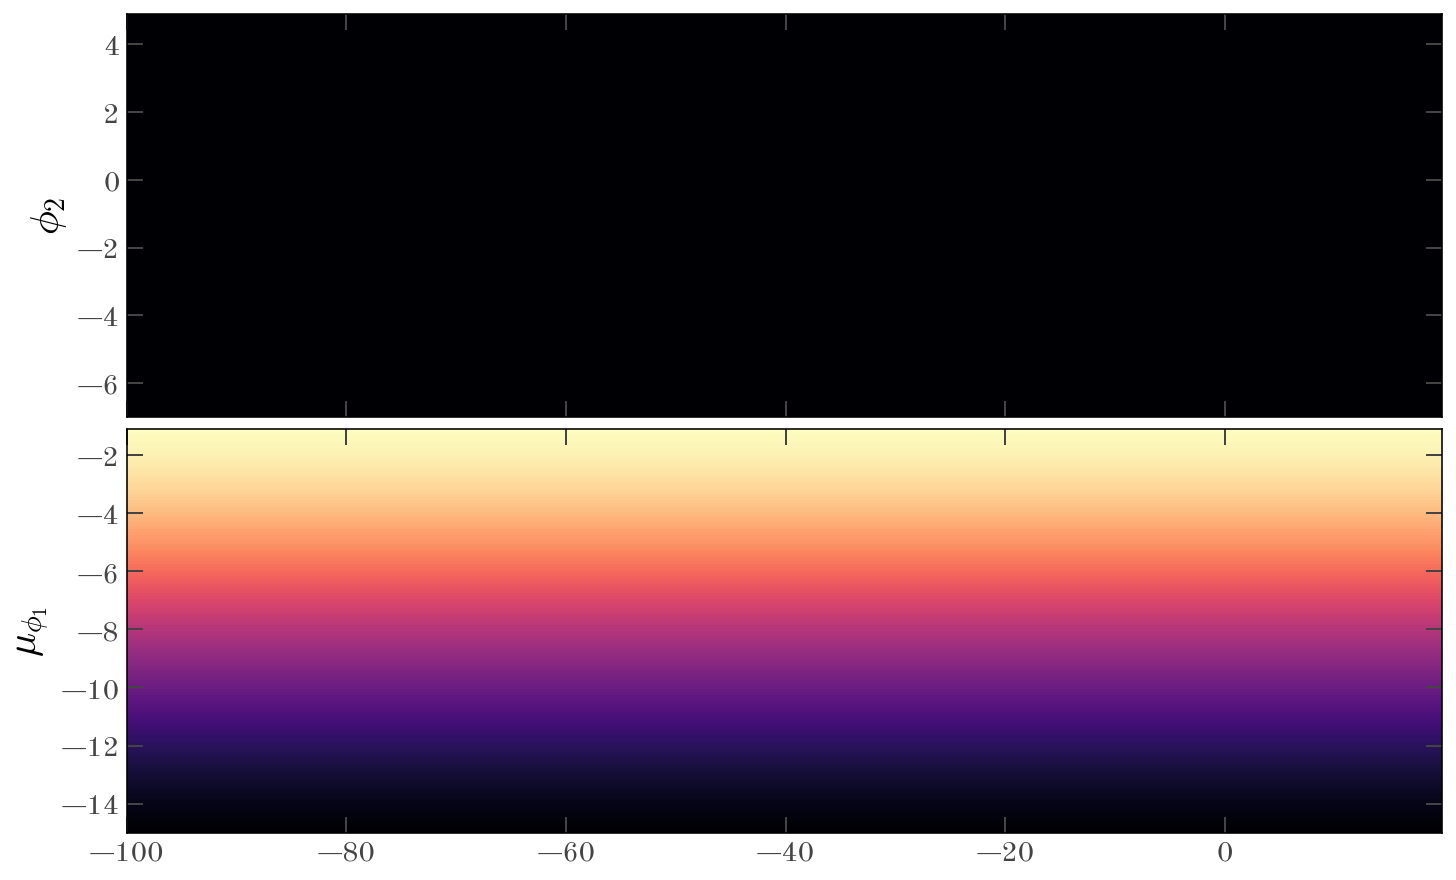

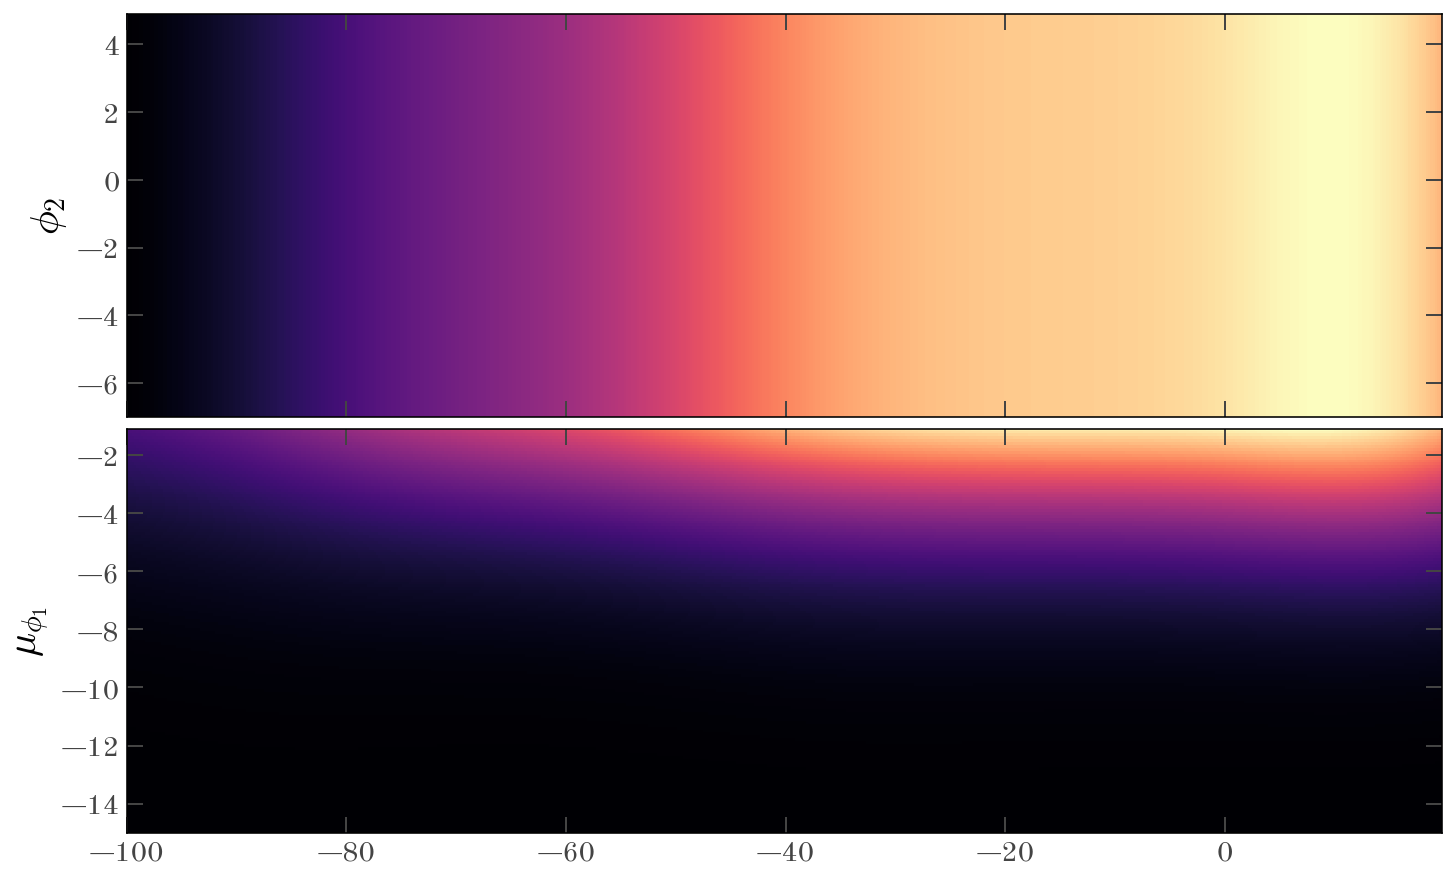

In [164]:
GD1BackgroundModel(bkg_init_p).plot_model_projections();
GD1BackgroundModel(bkg_opt_p).plot_model_projections();

In [165]:
stream_init_p = {
    "ln_n0": np.full(GD1StreamModel.shapes['ln_n0'], 5.),
    "phi2": {
        "mean": np.full(GD1StreamModel.shapes['phi2']['mean'], 0.),
        "ln_std": np.full(GD1StreamModel.shapes['phi2']['ln_std'], -1)
    },
    "pm1": {
        "mean": np.full(GD1StreamModel.shapes['pm1']['mean'], -10),
        "ln_std": np.full(GD1StreamModel.shapes['pm1']['ln_std'], -2.),
    }
}
stream_init_p['pm1']['mean'][5] = -15.1
stream_opt_p, stream_info = GD1StreamModel.optimize(
    stream_data, stream_init_p, 
    use_bounds=False,
    jaxopt_kwargs=dict(options=dict(disp=True, gtol=1e-10))
)

         Current function value: -2.621564
         Iterations: 307
         Function evaluations: 354
         Gradient evaluations: 342


In [166]:
stream_info

ScipyMinimizeInfo(fun_val=DeviceArray(-2.6215638, dtype=float64, weak_type=True), success=False, status=2, iter_num=307)

In [167]:
opt_what = GD1StreamModel(stream_opt_p)
-opt_what.ln_likelihood(stream_data)

DeviceArray(-5449.16534438, dtype=float64)

In [168]:
init_what = GD1StreamModel(stream_init_p)
-init_what.ln_likelihood(stream_data)

DeviceArray(504469.46381671, dtype=float64)

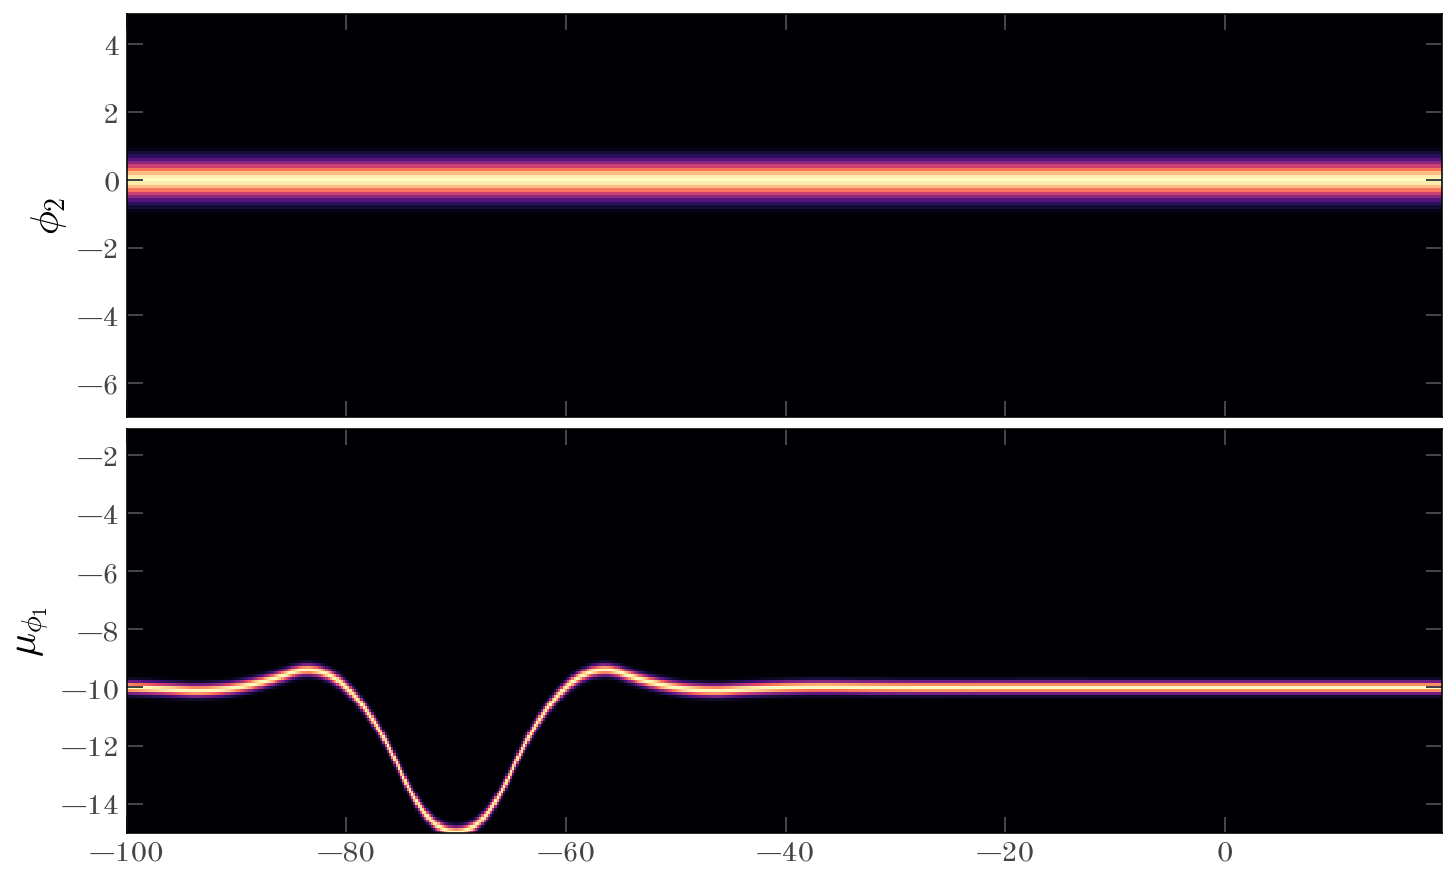

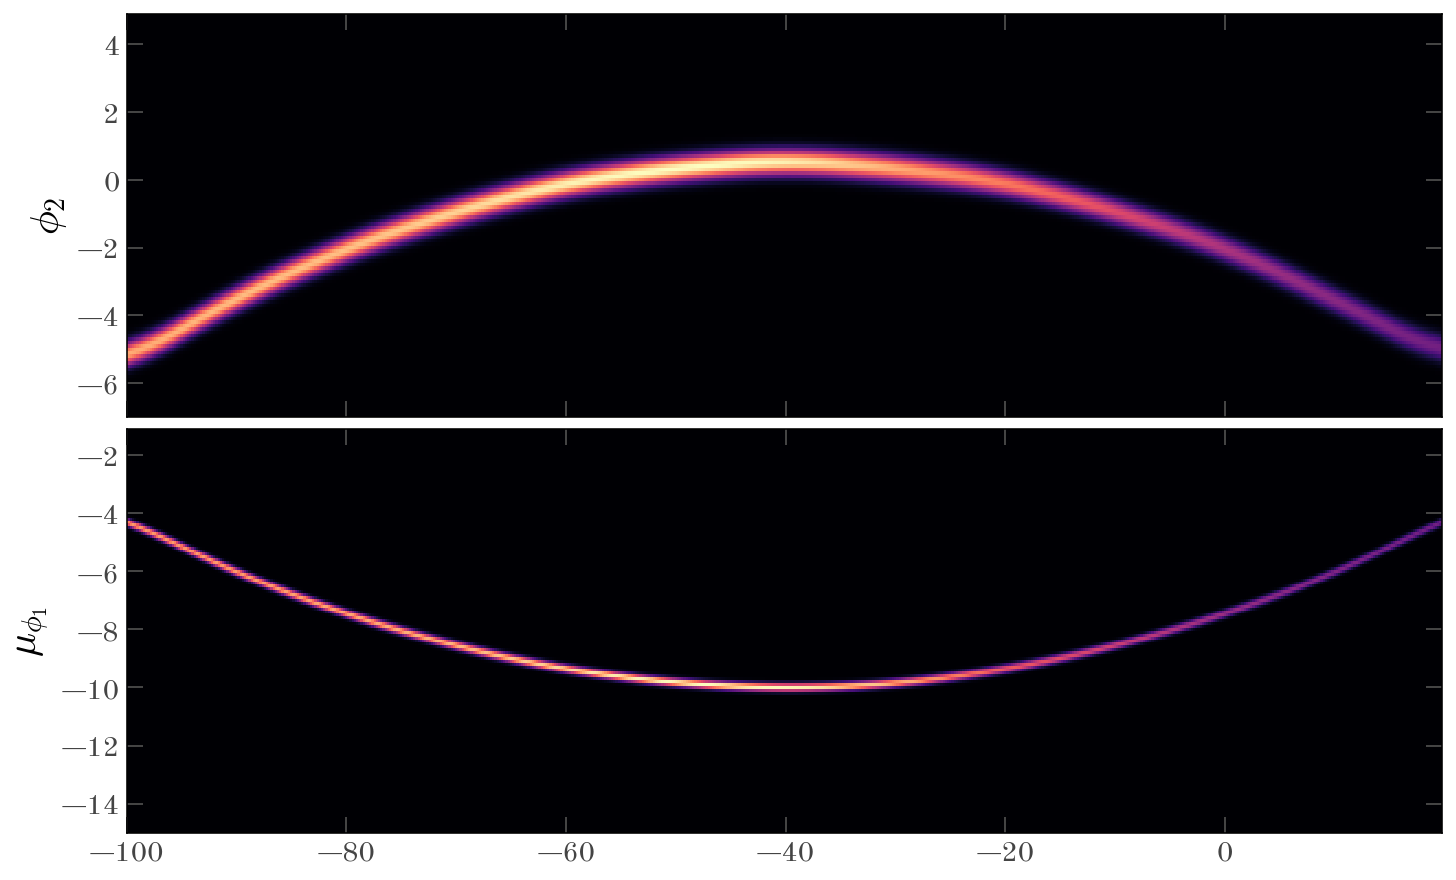

In [169]:
GD1StreamModel(stream_init_p).plot_model_projections();
GD1StreamModel(stream_opt_p).plot_model_projections();

(<Figure size 576x864 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'stream'}, ylabel='ln_n0'>,
        <AxesSubplot: ylabel='phi2'>, <AxesSubplot: ylabel='pm1'>],
       dtype=object))

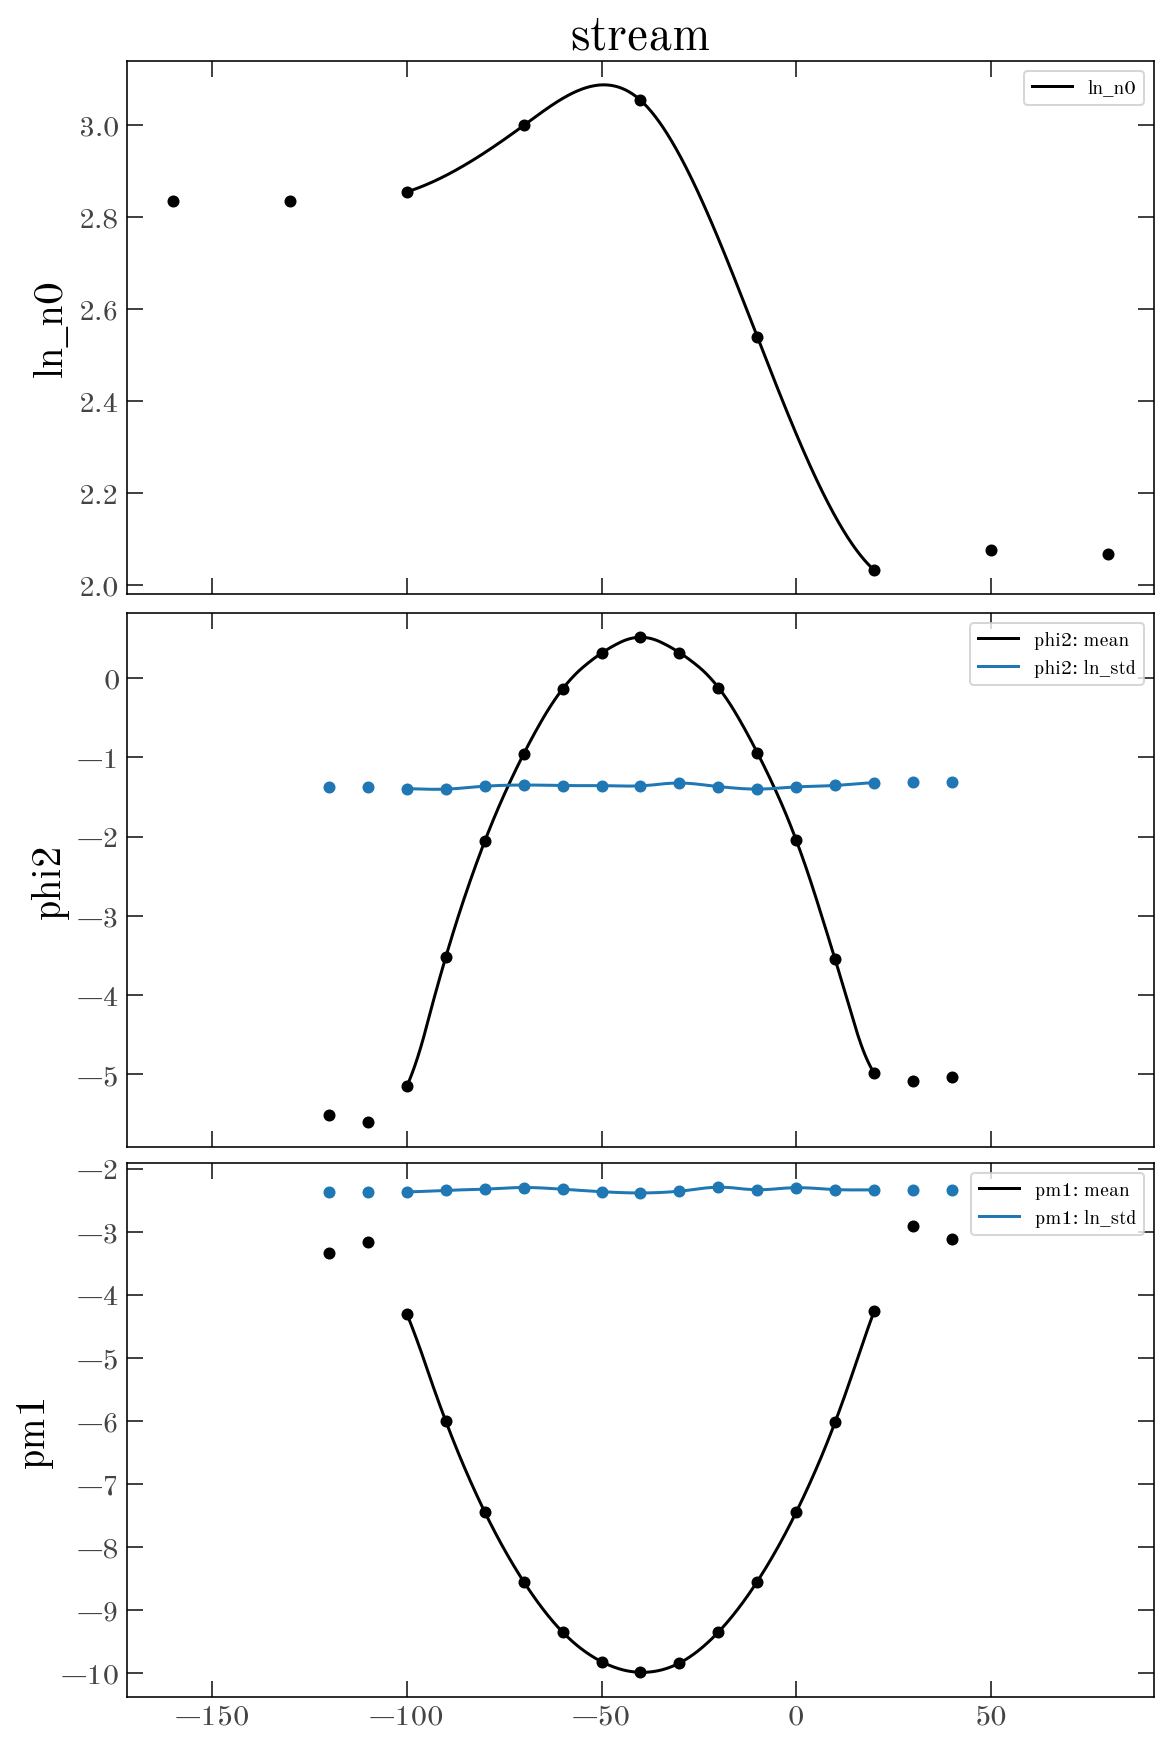

In [170]:
GD1StreamModel(stream_opt_p).plot_knots()

# Fit both simultaneously

In [171]:
mix_init = SplineDensityMixtureModel([
    GD1StreamModel(stream_opt_p), GD1BackgroundModel(bkg_opt_p)
])

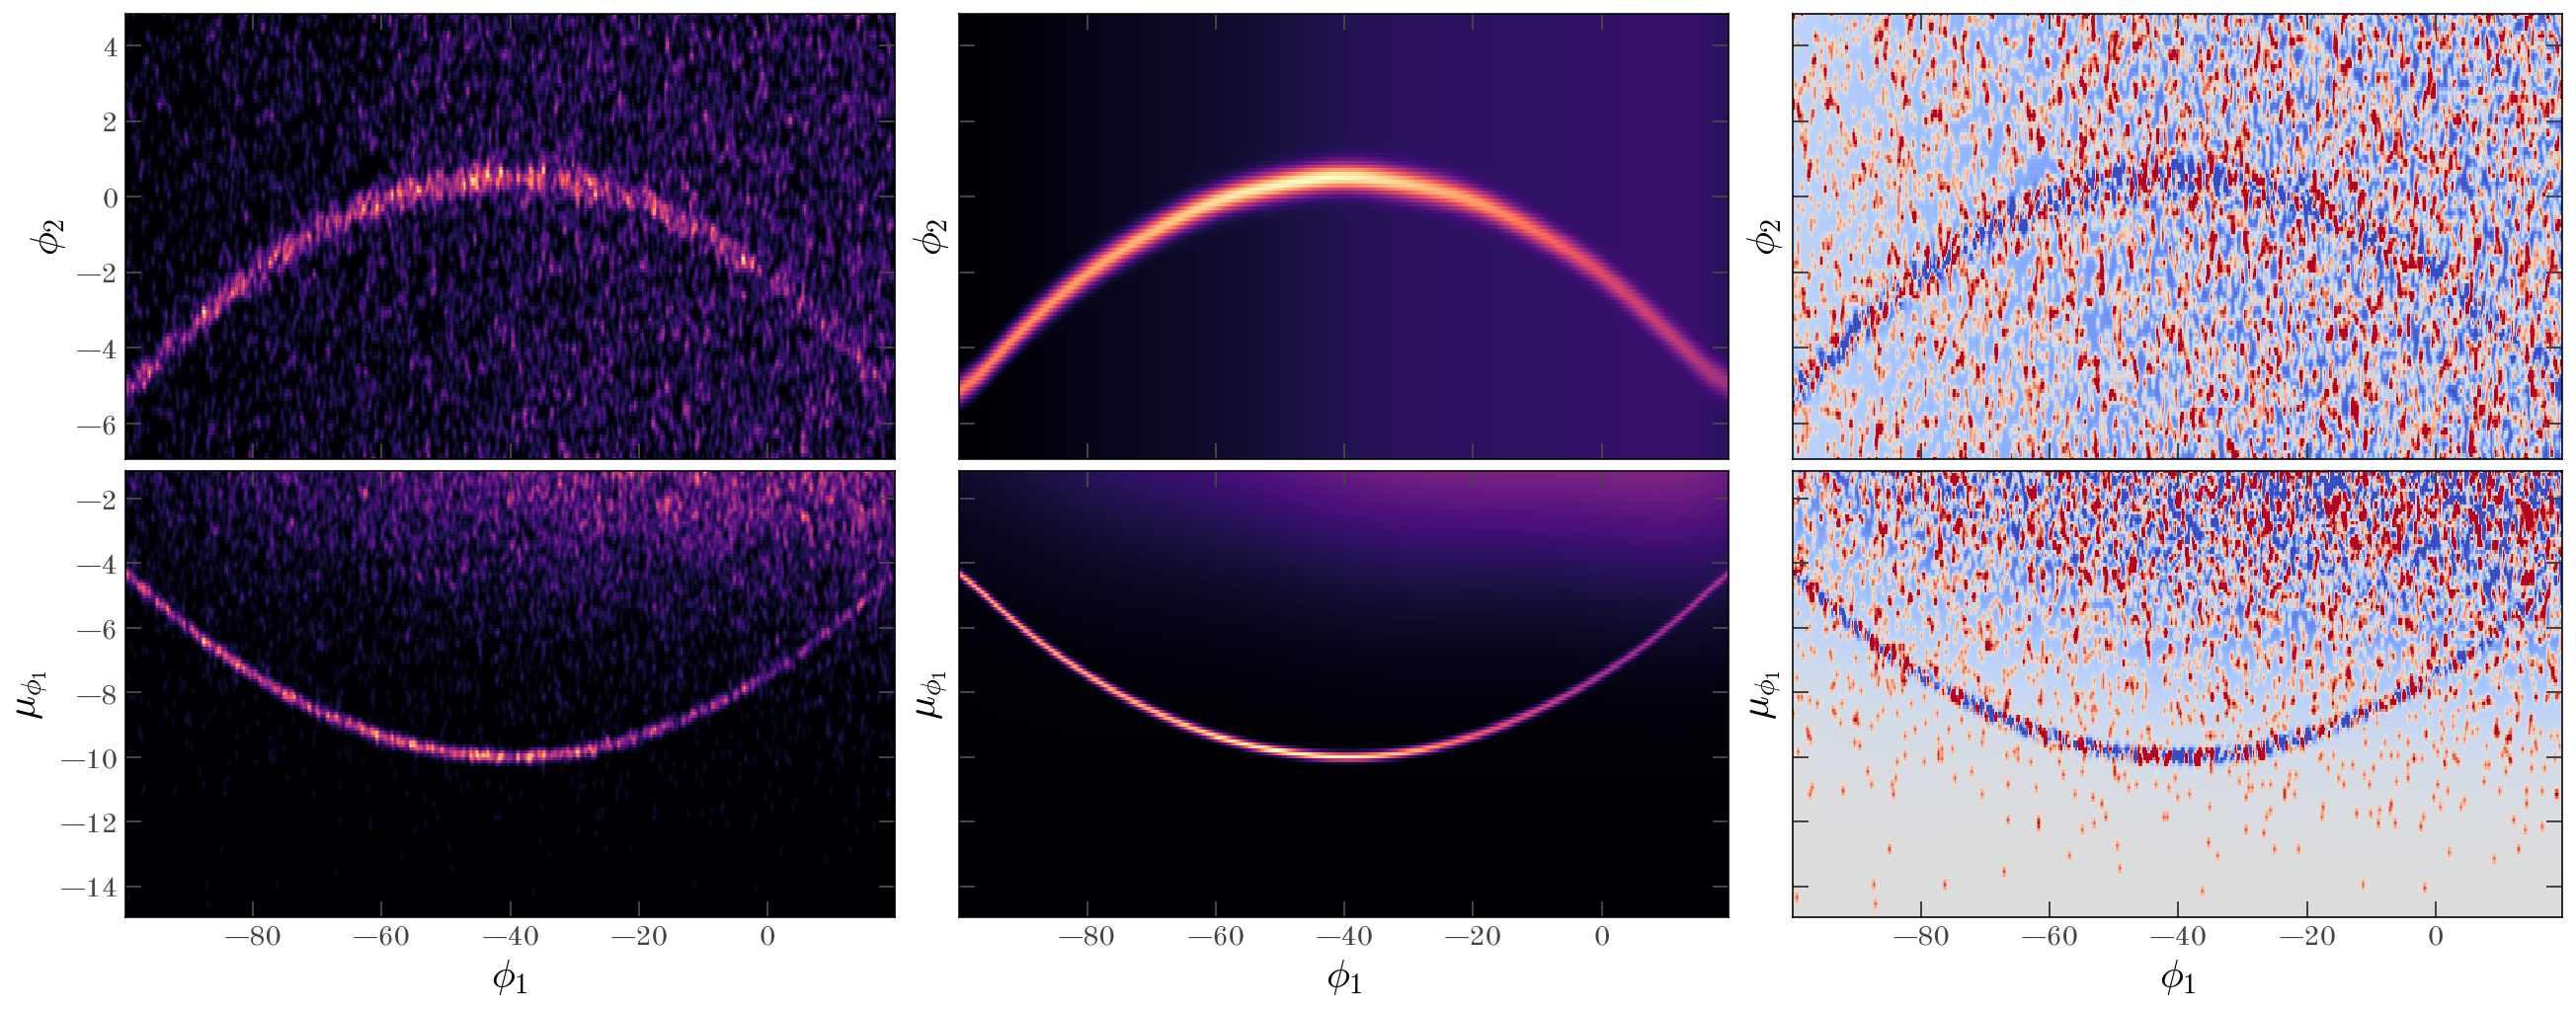

In [172]:
fig, axes = plt.subplots(
    len(mix_init.coord_names), 
    3, 
    figsize=(18, 3.5 * len(mix_init.coord_names)), 
    sharex=True, sharey='row', constrained_layout=True
)

axes = np.atleast_2d(axes)
plot_data_projections(data=all_data, grids=mix_init.default_grids, axes=axes[:, 0]);
mix_init.plot_model_projections(axes=axes[:, 1]);
mix_init.plot_residual_projections(data=all_data, axes=axes[:, 2])
    
for ax in axes[-1]:
    ax.set_xlabel(r'$\phi_1$')

In [175]:
mix_opt_pars, mix_info = SplineDensityMixtureModel.optimize(
    data=all_data, 
    init_params={"stream": stream_opt_p, "background": bkg_opt_p}, 
    Components=[GD1StreamModel, GD1BackgroundModel],
    jaxopt_kwargs=dict(maxiter=2048),
    use_bounds=False
)

In [176]:
mix_info

ScipyMinimizeInfo(fun_val=DeviceArray(1.01603171, dtype=float64, weak_type=True), success=False, status=2, iter_num=667)

In [177]:
# mix_opt_pars

(<Figure size 576x864 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'stream'}, ylabel='ln_n0'>,
        <AxesSubplot: ylabel='phi2'>, <AxesSubplot: ylabel='pm1'>],
       dtype=object))

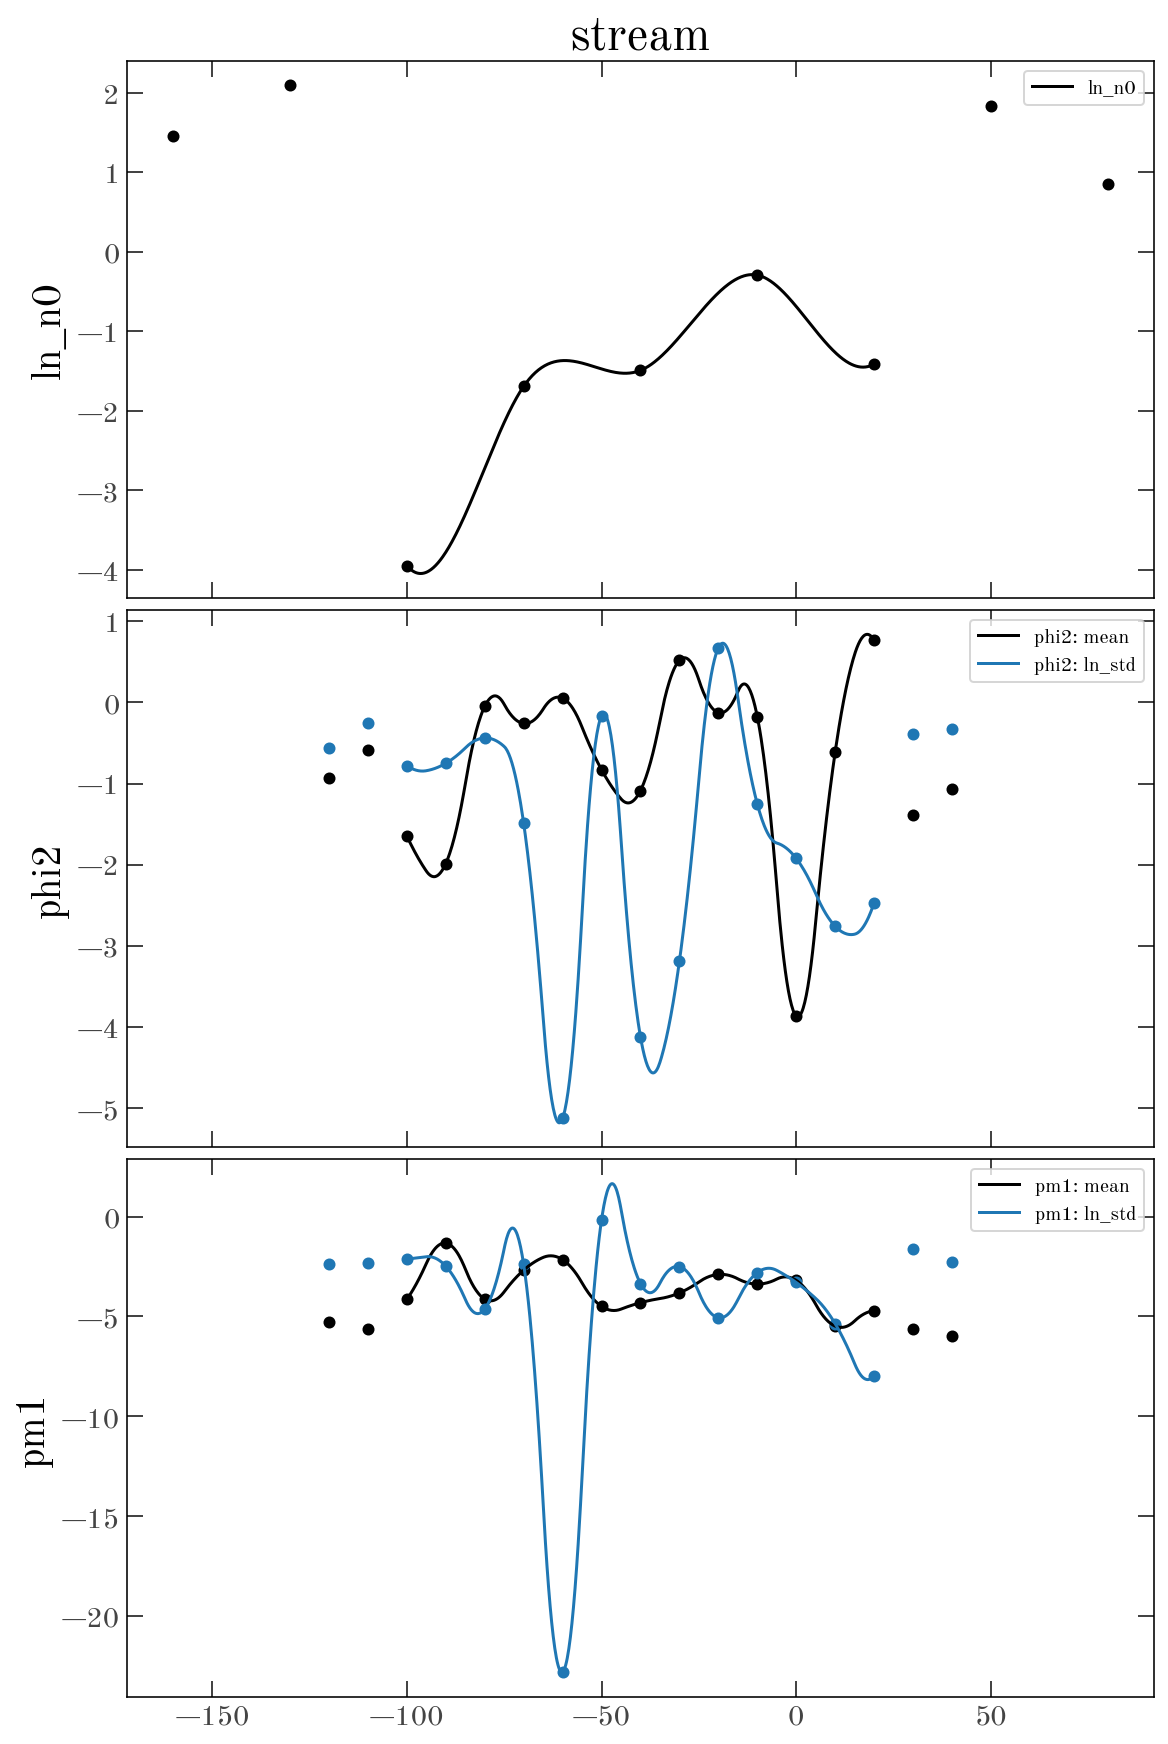

In [178]:
GD1StreamModel(mix_opt_pars['stream']).plot_knots()

In [179]:
mix_opt = SplineDensityMixtureModel([
    GD1StreamModel(mix_opt_pars['stream']), 
    GD1BackgroundModel(mix_opt_pars['background'])
])

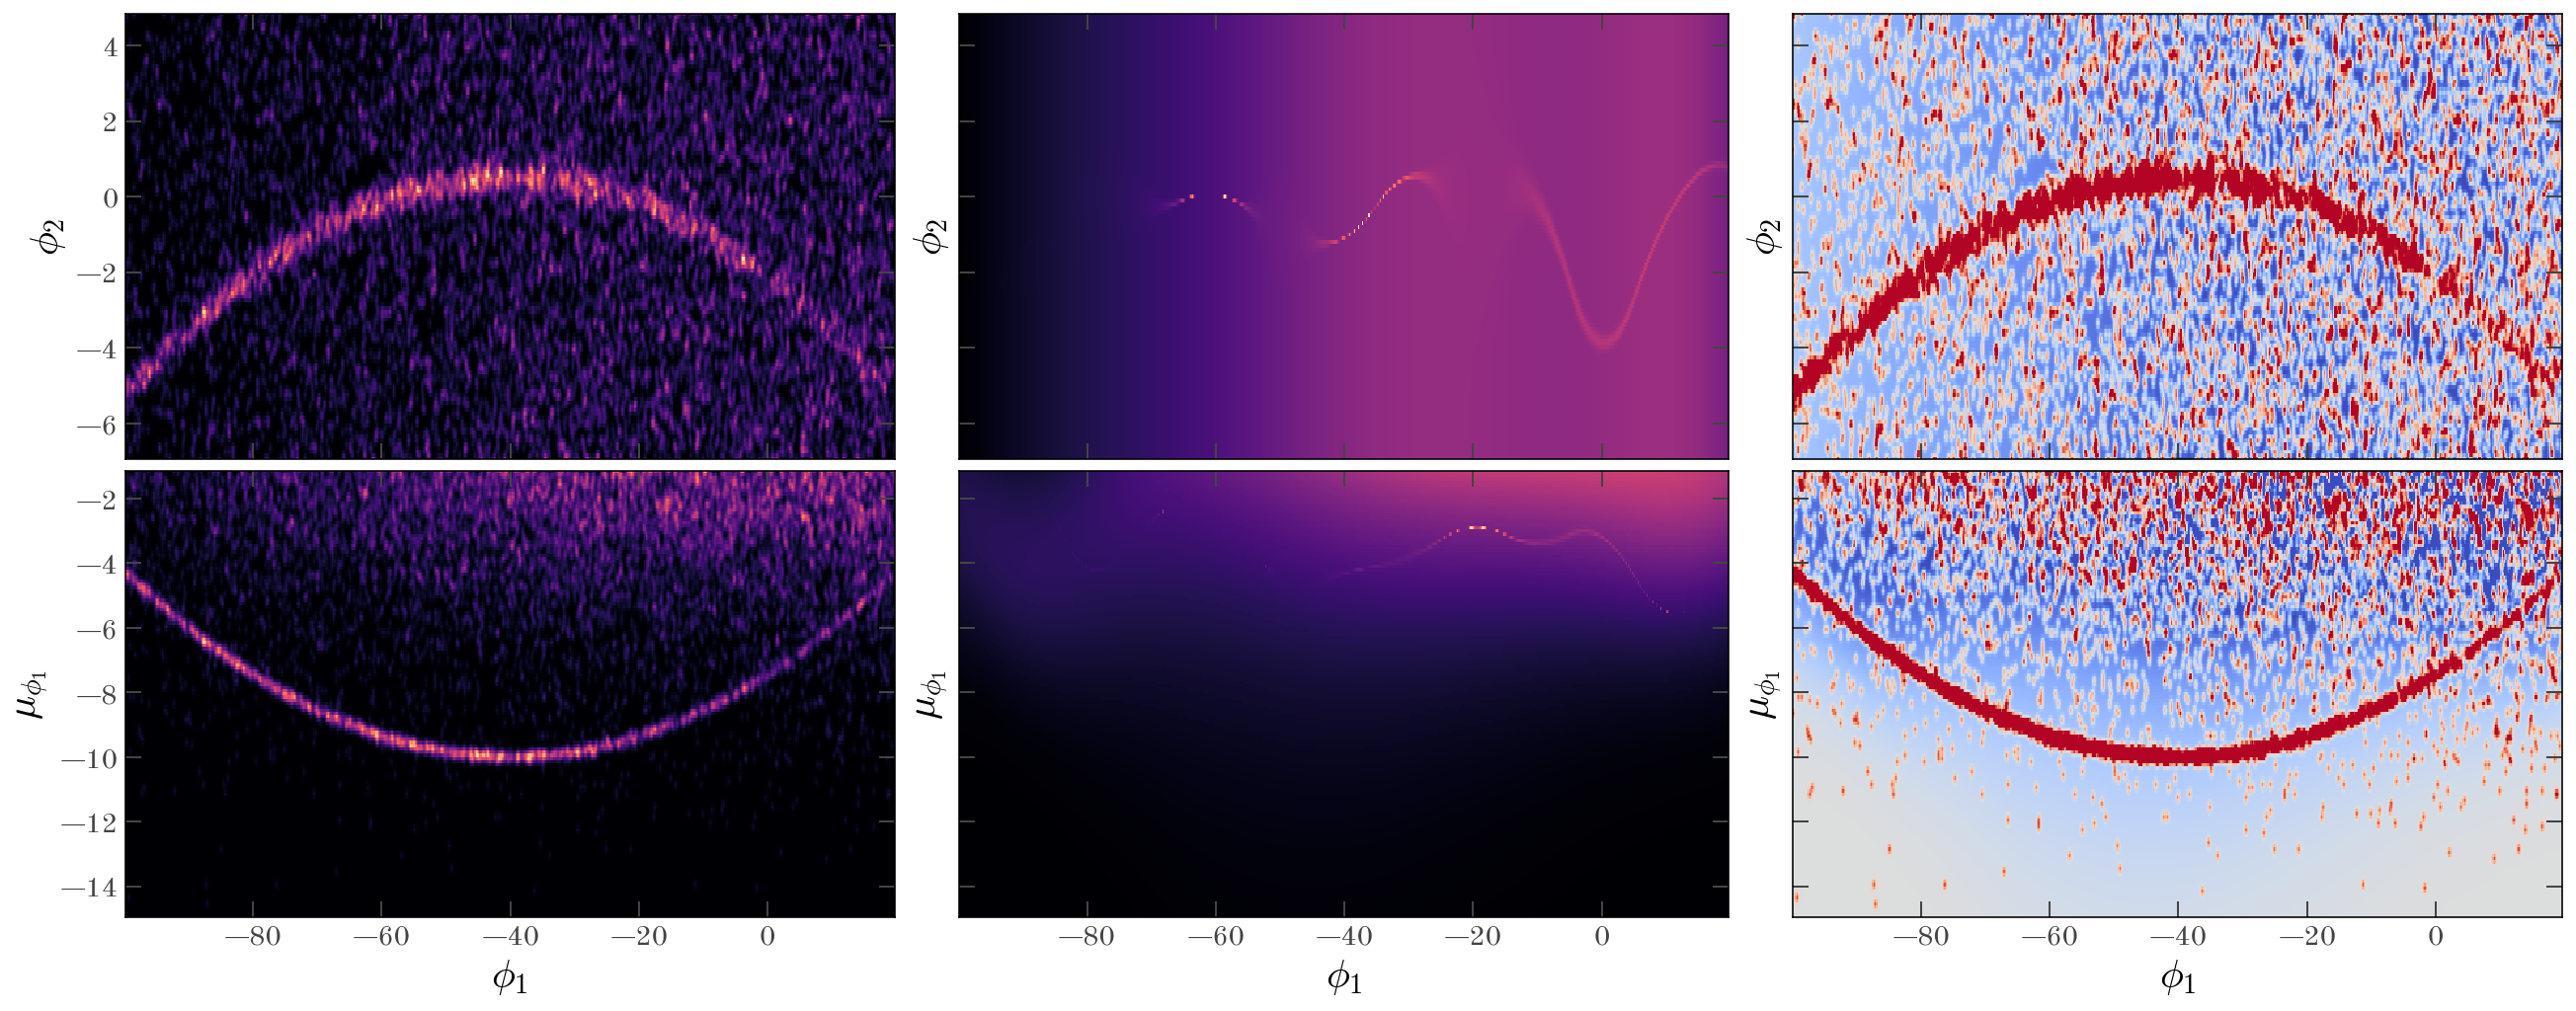

In [180]:
fig, axes = plt.subplots(
    len(mix_opt.coord_names), 
    3, 
    figsize=(18, 3.5 * len(mix_opt.coord_names)), 
    sharex=True, sharey='row', constrained_layout=True
)

axes = np.atleast_2d(axes)
plot_data_projections(data=all_data, grids=mix_opt.default_grids, axes=axes[:, 0]);
mix_opt.plot_model_projections(axes=axes[:, 1]);
mix_opt.plot_residual_projections(data=all_data, axes=axes[:, 2])
    
for ax in axes[-1]:
    ax.set_xlabel(r'$\phi_1$')